In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import pandas as pd

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

In [3]:
train_set=pd.read_pickle('/content/integrators_next_state_train.pickle')
test_set=pd.read_pickle('/content/integrators_next_state_test.pickle')

In [4]:
train_set=[trace.to(device) for trace in train_set]
test_set=[trace.to(device) for trace in test_set]

In [8]:
long_traces=[trace for trace in train_set if len(trace)>8]

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.relu1=nn.ReLU()
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu2=nn.ReLU()
        self.fc = nn.Linear(output_size, output_size)
        self.sigmoid=nn.Sigmoid()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden))
        hidden = self.relu1(self.i2h(combined))
        output = self.relu2(self.h2o(hidden))
        output = self.sigmoid(self.fc(output))
        return output, hidden

    def initHidden(self):
        #return torch.zeros(self.hidden_size).to(device)
        return torch.rand(self.hidden_size).to(device)

In [223]:
n_iters = 50
print_every = 10000
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
batch_size=16
regression_loss_function=nn.MSELoss()
classification_loss_function=nn.BCELoss()
n_hidden = 10
dimension=train_set[0][0].size(0)
rnn = RNN(dimension,n_hidden,dimension)
rnn.to(device)
optimizer=optim.SGD(rnn.parameters(),learning_rate)

In [224]:
losses=[]
losses_regression=[]
losses_classification=[]
position_in_trace=[]
losses_by_class={0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[]}

length_of_trace=[]

count=0

# Modify the loop to batch the training data
for iter in range(1, n_iters + 1):
    for batch_start in range(0, len(train_set), batch_size):
        batch_end = min(batch_start + batch_size, len(train_set))
        batch_traces = train_set[batch_start:batch_end]

        # Initialize gradients
        optimizer.zero_grad()

        for trace in batch_traces:
            hidden = rnn.initHidden()
            for i in range(len(trace) - 1):
                output, hidden = rnn(trace[i], hidden)
                hidden = hidden.clone().detach()

                # Calculate losses for regression and classification
                regression_output = torch.cat((output[0:3], output[-1].reshape(1)))
                regression_correct = torch.cat((trace[i + 1][0:3], trace[i + 1][-1].reshape(1)))
                classification_output = output[3:11]
                classification_correct = trace[i + 1][3:11]

                loss_regression = regression_loss_function(regression_output, regression_correct)
                loss_classification = classification_loss_function(classification_output, classification_correct)

                loss = loss_regression + 0.1*loss_classification

                # Accumulate gradients
                loss.backward()

                # Record losses
                if i>0 and len(trace)!=3 and len(trace)!=4:
                  losses.append(loss.detach().cpu().numpy())
                  losses_by_class[(classification_correct==1).nonzero().item()].append(loss.detach().cpu().numpy())
                  position_in_trace.append(i)
                  length_of_trace.append(len(trace))
                  losses_regression.append(loss_regression.detach().cpu().numpy())
                  losses_classification.append(loss_classification.detach().cpu().numpy())

                if count % print_every == 0 and count>1:
                  print(f"total losses are between {min(losses[-print_every:])} and {max(losses[-print_every:])}")
                  print(f"regression losses are between {min(losses_regression[-print_every:])} and {max(losses_regression[-print_every:])}")
                  print(f"classification losses are between {min(losses_classification[-print_every:])} and {max(losses_classification[-print_every:])}")
                  print(" ")
                count += 1

        # Update parameters based on accumulated gradients for the entire batch
        optimizer.step()




total losses are between 0.10902708768844604 and 0.20850706100463867
regression losses are between 0.03256627172231674 and 0.1333303302526474
classification losses are between 0.7124813199043274 and 0.7687326669692993
 
total losses are between 0.1049131229519844 and 0.20011280477046967
regression losses are between 0.028837746009230614 and 0.12475091218948364
classification losses are between 0.7069809436798096 and 0.7647876739501953
 
total losses are between 0.10108157992362976 and 0.187848299741745
regression losses are between 0.025644375011324883 and 0.11403437703847885
classification losses are between 0.7021768093109131 and 0.7611560821533203
 
total losses are between 0.097158282995224 and 0.17826054990291595
regression losses are between 0.022164929658174515 and 0.10553380846977234
classification losses are between 0.6973879337310791 and 0.7571678757667542
 
total losses are between 0.09320907294750214 and 0.16861984133720398
regression losses are between 0.018713917583227158

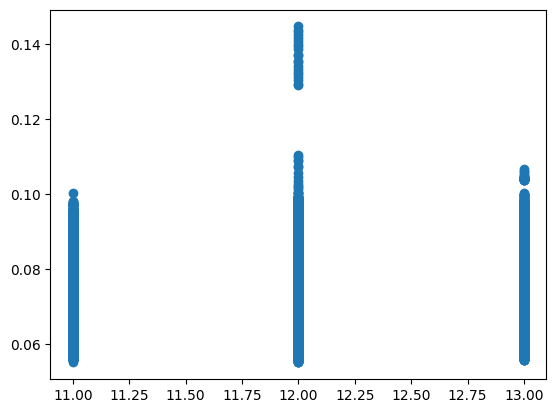

In [225]:
plt.scatter(length_of_trace[100000:],losses[100000:])


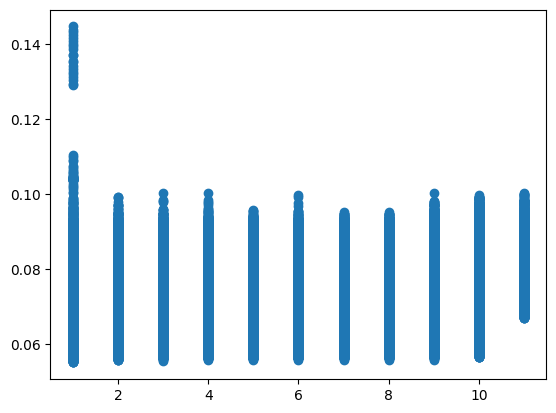

In [226]:
plt.scatter(position_in_trace[100000:],losses[100000:])


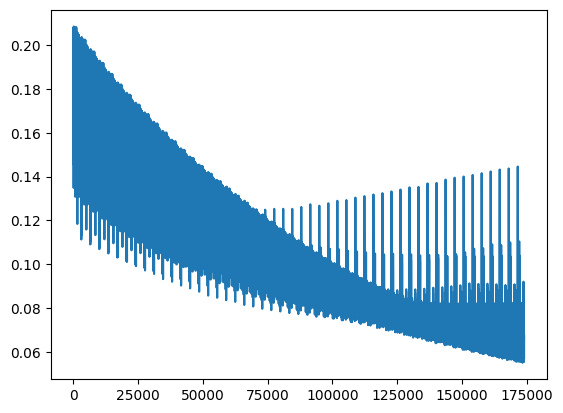

In [227]:
plt.plot(range(len(losses)),losses)


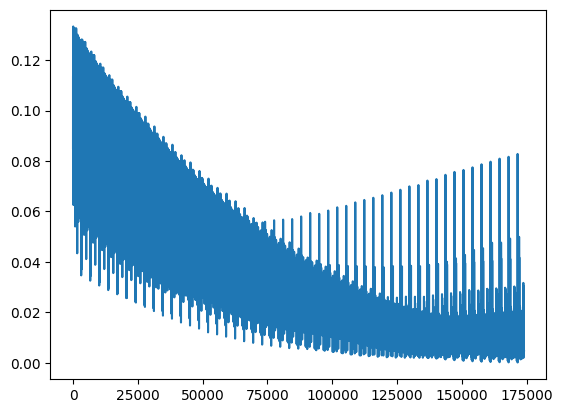

In [228]:
plt.plot(range(len(losses_regression)),losses_regression)


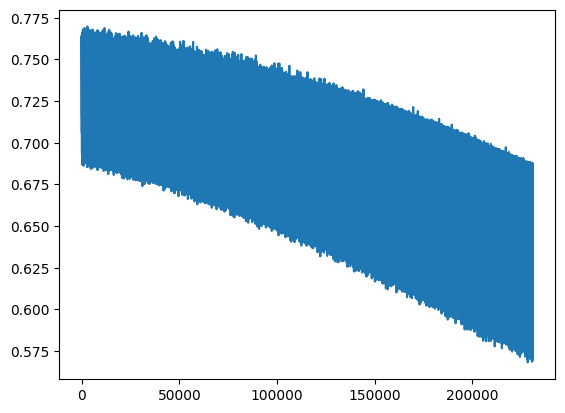

In [214]:
plt.plot(range(len(losses_classification)),losses_classification)


In [171]:
for i in range(8):
  print(np.mean(losses_by_class[i]))

0.11668015
0.11841555
0.10664893
0.11579222
0.12737142
0.11300366
0.13245197
0.11772076


In [168]:
frequency_of_classes=np.zeros(8)
for trace in train_set:
  for i in range(2,len(trace)):
    clas=trace[i][3:11]
    frequency_of_classes[(clas==1).nonzero().item()]+=1

In [169]:
frequency_of_classes

array([  39.,   45.,   38.,   34.,   26., 3017.,  293.,  347.])

In [44]:
def evaluate(nn,trace):
    losses_regression=[]
    correct=0
    hidden = nn.initHidden()
    for i in range(len(trace)-1):
        output,hidden=nn(trace[i],hidden)

        regression_output=torch.cat((output[0:3],output[-1].reshape(1)))
        regression_correct=torch.cat((trace[i+1][0:3],trace[i+1][-1].reshape(1)))

        classification_output=(output[3:11]>=0.5)
        classification_correct=(trace[i+1][3:11]>=0.5)

        loss_regression=regression_loss_function(regression_output,regression_correct)
        losses_regression.append(loss_regression)

        if torch.equal(classification_output,classification_correct):
          correct+=1

    return losses_regression,correct


Accuracy is 68.21773485513609%
Mean loss is 0.008444787003099918


(array([  2.,   3.,  13.,  36., 151., 322., 247., 136.,  40.,  40.,  34.,
         29.,  26.,  16.,   5.,   3.,   6.,   3.,   2.,   1.,   4.,   5.,
          2.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.00070909, 0.00176861, 0.00282813, 0.00388764, 0.00494716,
        0.00600667, 0.00706619, 0.00812571, 0.00918522, 0.01024474,
        0.01130426, 0.01236377, 0.01342329, 0.0144828 , 0.01554232,
        0.01660184, 0.01766135, 0.01872087, 0.01978039, 0.0208399 ,
        0.02189942, 0.02295893, 0.02401845, 0.

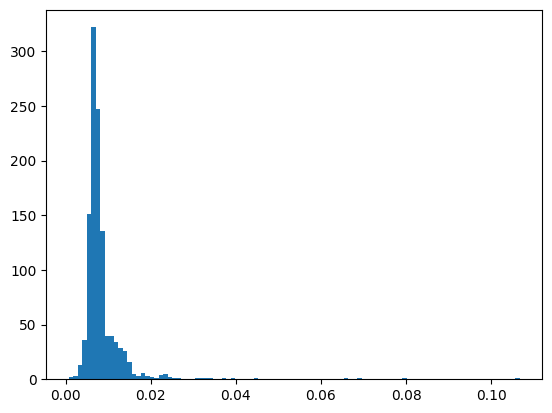

In [188]:
losses=[]
correct=0
tot=0
for trace in test_set:
    trace_losses,trace_correct=evaluate(rnn,trace)
    losses.extend(trace_losses)
    correct+=trace_correct
    tot+=len(trace)-1

losses=[loss.detach().cpu().numpy() for loss in losses]
print(f"Accuracy is {(correct/tot)*100}%" )
print(f"Mean loss is {np.mean(losses)}")
plt.hist(losses,bins=100)

In [45]:
print(test_set[5])
hidden=rnn.initHidden()
rnn(test_set[5][0],hidden)

tensor([[0.3066, 0.9117, 0.0195, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.2050],
        [0.3066, 0.9117, 0.1543, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2371],
        [0.4188, 0.9117, 0.1543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000]])


(tensor([0.4737, 0.8346, 0.2746, 0.2051, 0.1739, 0.1693, 0.1673, 0.1589, 0.6644,
         0.1985, 0.1675, 0.1263], grad_fn=<SigmoidBackward0>),
 tensor([0.5362, 0.5692, 0.4343, 0.5372, 0.5127, 0.5215, 0.4979, 0.5028, 0.5803,
         0.5993], grad_fn=<SigmoidBackward0>))

In [ ]:
def squared_error(input,target):
  return torch.pow(input-target,2)

In [ ]:
class CustomLoss(nn.Module):
  def __init__(self):
        super(CustomLoss, self).__init__()

  def forward(self,input,target):
    mse=(1/4)*(squared_error(input[0],target[0])+squared_error(input[1],target[1])+squared_error(input[2],target[2])+squared_error(input[-1],target[-1]))
    l=torch.zeros(8)
    for i in range(len(l)):
      l[i]=-(target[i]*torch.log(input[i])+(1-target[i])*torch.log(1-input[i]))
    bce=torch.mean(l)
    return 0.5*mse+bce

In [ ]:
l=torch.zeros(3)
l[1]=2
l

tensor([0., 2., 0.])

In [ ]:
train_set[0]

tensor([[0.6102, 0.8874, 0.1609, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1765],
        [0.5267, 0.8874, 0.1609, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000]], device='cuda:0')